In [1]:
from huggingface_hub import login, HfApi
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.models.llama import LlamaConfig
import os
import time

# Hugging Faceにログイン
# 環境変数 HUGGINGFACE_TOKEN が設定されていれば自動的に利用
token = os.environ.get("HUGGINGFACE_TOKEN")
# モデルディレクトリと保存先パス
base_model_name = "meta-llama/Llama-3.1-70B-Instruct"

# ユーザー名を取得して/raidに保存パスを設定
user_dir = os.environ.get("USER")
save_directory = f"/raid/{user_dir}/{base_model_name.replace('/', '_')}"

# 保存ディレクトリを作成
os.makedirs(save_directory, exist_ok=True)
print(f"Model will be saved to: {save_directory}")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, #モデルのロードをint4で行う
    bnb_4bit_compute_dtype=torch.bfloat16, #計算はbfloat16で行う(オーバーフロー対策，精度向上)
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,  # ダブル量子化
    llm_int8_skip_modules=None  # 全て量子化対象(活性化関数も量子化)
)

# モデル構成の設定（rope_scaling対策）
config = LlamaConfig.from_pretrained(base_model_name, cache_dir=save_directory)
if hasattr(config, "rope_scaling"):
    config.rope_scaling["original_max_position_embeddings"] = 8191  

# トークナイザのロード
tokenizer = AutoTokenizer.from_pretrained(base_model_name, cache_dir=save_directory, token=token)

# pad_token_id を設定（未設定の場合）
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# 通常モデルのロード
model_base = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    config=config,        
    device_map="auto",           
    torch_dtype=torch.float64, #通常モデルはfloat64で読み込み，計算も行う
    cache_dir=save_directory,    
    token=token
)

# 量子化モデルのロード
model_quantized = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    config=config,   
    device_map="auto",           
    quantization_config=bnb_config,  
    cache_dir=save_directory,   
    token=token         
)

print("Model and tokenizer loaded successfully!")
print(f"All files are saved in: {save_directory}")


Model will be saved to: /raid/sasaki/meta-llama_Llama-3.1-70B-Instruct


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Model and tokenizer loaded successfully!
All files are saved in: /raid/sasaki/meta-llama_Llama-3.1-70B-Instruct


In [2]:
def print_model_device_info(model, model_name):
    # モデル全体のデバイス情報を取得
    device_set = {param.device for param in model.parameters()}
    devices_info = ", ".join(str(device) for device in device_set)

    # メモリ使用量を取得
    memory_usage = {
        f"GPU {i}": torch.cuda.memory_allocated(i) / (1024 ** 3)  # GB単位
        for i in range(torch.cuda.device_count())
    }

    # 出力
    print(f"Model Name: {model_name}")
    print(f"Devices: {devices_info}")
    print("Memory Usage (per GPU):")
    for gpu, usage in memory_usage.items():
        print(f"  {gpu}: {usage:.2f} GB")
    print()

# モデル情報とメモリフットプリントを表示
print_model_device_info(model_base, "Base Model")
print_model_device_info(model_quantized, "Quantized Model")




Model Name: Base Model
Devices: cuda:0, cuda:1, cuda:2, cuda:3, cuda:4, cuda:5, cuda:6, cuda:7
Memory Usage (per GPU):
  GPU 0: 68.81 GB
  GPU 1: 74.24 GB
  GPU 2: 74.24 GB
  GPU 3: 74.24 GB
  GPU 4: 74.24 GB
  GPU 5: 74.24 GB
  GPU 6: 74.24 GB
  GPU 7: 48.24 GB

Model Name: Quantized Model
Devices: cuda:0, cuda:1, cuda:2, cuda:3, cuda:4, cuda:5, cuda:6, cuda:7
Memory Usage (per GPU):
  GPU 0: 68.81 GB
  GPU 1: 74.24 GB
  GPU 2: 74.24 GB
  GPU 3: 74.24 GB
  GPU 4: 74.24 GB
  GPU 5: 74.24 GB
  GPU 6: 74.24 GB
  GPU 7: 48.24 GB



In [3]:
def generate_output(model, tokenizer, input_text: str) -> str:
    """
    モデルとトークナイザを用いて出力を生成し、'Yes' または 'No' を抽出して返す。
    """
    # プロンプトを作成
    prompt = "Input: {}\nOutput:".format(input_text)
    
    # トークナイズ
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # 不要なフィールドを削除（トークナイザによっては token_type_ids が不要）
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    # 応答生成
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    
    # 出力をデコード
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # "Output:"以降の部分を取得し、トリム
    processed_output = output_text.split("Output:")[-1].strip()
    
    # 結果を返す（"Yes" または "No"）
    return processed_output

In [ ]:
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import time

# GLUEデータセットのロード（例: MRPCタスク）
glue_task = "mrpc"  # 使用するタスク（ここではMRPCを例とする）
glue_dataset = load_dataset("glue", glue_task, split="train") 


def extract_label_from_output(output: str) -> int:
    output = output.strip().lower()
    if "yes" in output:
        return 1
    elif "no" in output:
        return 0
    else:
        return -1  # デフォルト

        
# 正答判定関数
def is_correct(prediction: int, reference: int) -> int:
    """
    モデルの予測ラベルが参照ラベルと一致しているかを判定します。
    """
    return int(prediction == reference)

# 結果を保存するリスト
results = []
base_output_list = []
quantize_output_list = []
# データセットを処理
for example in tqdm(glue_dataset, desc="Processing GLUE Dataset"):
    # 入力文を生成
    input_text = f"Answer only 'Yes' or 'No' based on whether the two sentences have the same meaning. Sentence1: {example['sentence1']} ,Sentence2: {example['sentence2']}."


    reference_label = example["label"]  # 正解ラベル（0 または 1）

    # Baseモデルで生成
    start_time = time.time()
    base_output = generate_output(model_base, tokenizer, input_text)
    base_time = time.time() - start_time
    base_predicted_label = extract_label_from_output(base_output)
    base_correct = is_correct(base_predicted_label, reference_label)
    base_output_list.append(base_output)
    # Quantizedモデルで生成
    start_time = time.time()
    quantized_output = generate_output(model_quantized, tokenizer, input_text)
    quantized_time = time.time() - start_time
    quantized_predicted_label = extract_label_from_output(quantized_output)
    quantized_correct = is_correct(quantized_predicted_label, reference_label)
    quantize_output_list.append(quantized_output)
    # 結果をリストに追加
    results.append({
        "problem": input_text,
        "reference_label": reference_label,
        "base_model_predicted": base_predicted_label,
        "base_model_correct": base_correct,
        "quantized_model_predicted": quantized_predicted_label,
        "quantized_model_correct": quantized_correct,
        "base_model_time": base_time,
        "quantized_model_time": quantized_time
    })

# 結果をデータフレームに変換
df_results = pd.DataFrame(results)

from datetime import datetime

# 現在の日時を取得
current_time = datetime.now().strftime("%Y%m%d_%H%M%S") 

# ファイル名に必要な情報を含める
csv_filename = f"glue_comparison_results_{base_model_name.replace('/', '_')}_{glue_task}_{current_time}.csv"

# 結果をCSVに保存
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Processing GLUE Dataset:   0%|                 | 7/3668 [01:00<5:44:29,  5.65s/it]

In [ ]:
import pandas as pd

csv_filename = f"glue_comparison_results_meta-llama_Llama-3.1-70B-Instruct_mrpc_20241129_162631.csv"

# CSVファイルを読み込む
df_results = pd.read_csv(csv_filename)
print(f"Results loaded from {csv_filename}")

# 各種統計情報の計算
summary = {
    "base_model_accuracy": df_results["base_model_correct"].mean() * 100,  # Baseモデルの正答率 (%)
    "quantized_model_accuracy": df_results["quantized_model_correct"].mean() * 100,  # 量子化モデルの正答率 (%)
    "base_model_avg_time": df_results["base_model_time"].mean(),  # Baseモデルの平均実行時間 (秒)
    "quantized_model_avg_time": df_results["quantized_model_time"].mean(),  # 量子化モデルの平均実行時間 (秒)
    "base_model_time_std": df_results["base_model_time"].std(),  # Baseモデル実行時間の標準偏差 (秒)
    "quantized_model_time_std": df_results["quantized_model_time"].std()  # 量子化モデル実行時間の標準偏差 (秒)
}

# 結果を表示
print("Summary Statistics:")
for key, value in summary.items():
    print(f"{key}: {value:.2f}")

# 結果を新たなデータフレームに変換して保存
summary_df = pd.DataFrame([summary])




In [13]:
df_results['problem'][0]

'Sentence1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Sentence2: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .. Answer only \'Yes\' or \'No\' based on whether the two sentences have the same meaning.'

Summary Statistics:
base_model_accuracy: 64.50
quantized_model_accuracy: 67.50
base_model_avg_time: 1.21
quantized_model_avg_time: 0.57
base_model_time_std: 5.07
quantized_model_time_std: 0.05


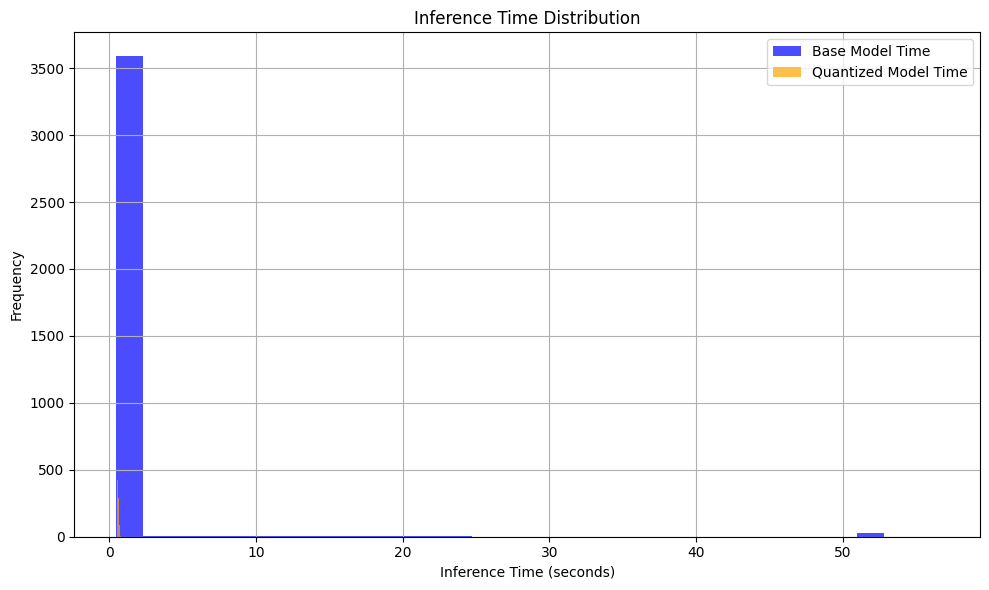

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 正答率と推論時間の統計情報を計算
summary = {
    "base_model_accuracy": df_results["base_model_correct"].mean() * 100,  # Baseモデルの正答率 (%)
    "quantized_model_accuracy": df_results["quantized_model_correct"].mean() * 100,  # 量子化モデルの正答率 (%)
    "base_model_avg_time": df_results["base_model_time"].mean(),  # Baseモデルの平均実行時間 (秒)
    "quantized_model_avg_time": df_results["quantized_model_time"].mean(),  # 量子化モデルの平均実行時間 (秒)
    "base_model_time_std": df_results["base_model_time"].std(),  # Baseモデル実行時間の標準偏差 (秒)
    "quantized_model_time_std": df_results["quantized_model_time"].std()  # 量子化モデル実行時間の標準偏差 (秒)
}

# 結果を表示
print("Summary Statistics:")
for key, value in summary.items():
    print(f"{key}: {value:.2f}")

# 推論時間の分布を可視化
plt.figure(figsize=(10, 6))

# Baseモデルの推論時間
plt.hist(df_results["base_model_time"], bins=30, alpha=0.7, label="Base Model Time", color="blue")

# 量子化モデルの推論時間
plt.hist(df_results["quantized_model_time"], bins=30, alpha=0.7, label="Quantized Model Time", color="orange")

# グラフの装飾
plt.title("Inference Time Distribution")
plt.xlabel("Inference Time (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()


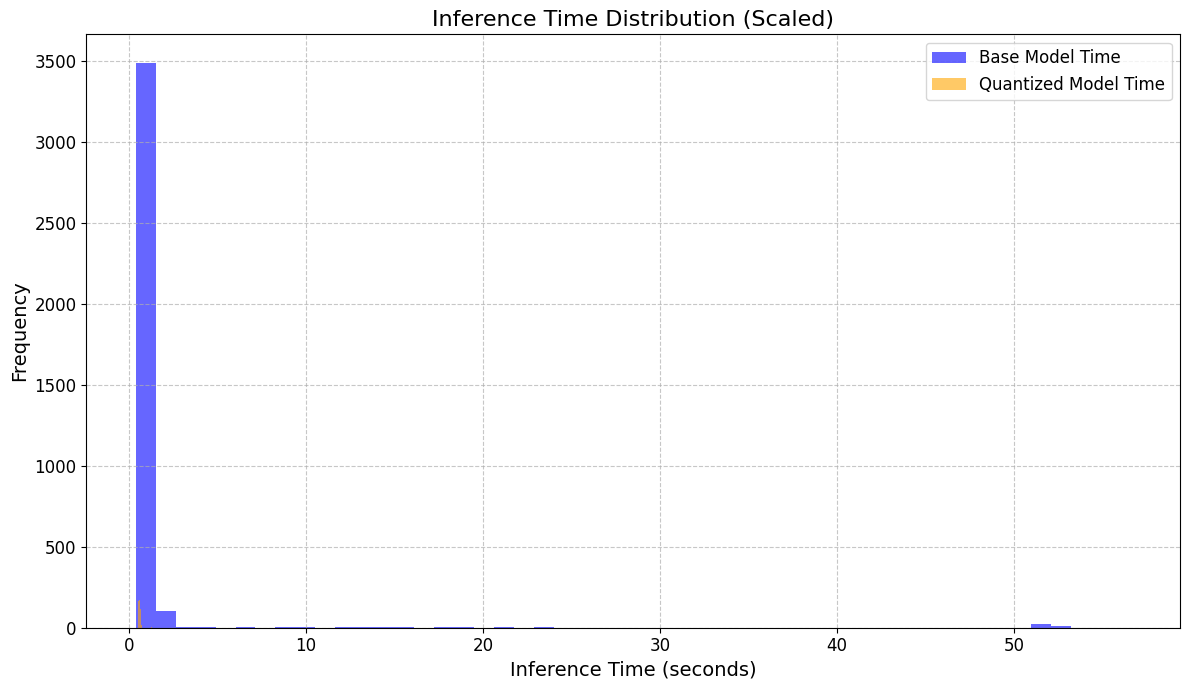

Label Bias:
   Label  Count  Percentage
0      1   2474   67.448201
1      0   1194   32.551799


In [9]:
import matplotlib.pyplot as plt

# 推論時間の分布を可視化（スケール調整付き）
plt.figure(figsize=(12, 7))

# Baseモデルの推論時間（ヒストグラムの幅調整）
plt.hist(df_results["base_model_time"], bins=50, alpha=0.6, label="Base Model Time", color="blue")

# 量子化モデルの推論時間
plt.hist(df_results["quantized_model_time"], bins=50, alpha=0.6, label="Quantized Model Time", color="orange")

# グラフの装飾
plt.title("Inference Time Distribution (Scaled)", fontsize=16)
plt.xlabel("Inference Time (seconds)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# グラフの表示
plt.tight_layout()
plt.show()

# 元のラベルの偏りを確認
label_counts = df_results["reference_label"].value_counts()
label_bias = label_counts / label_counts.sum() * 100  # 割合計算
label_bias_df = pd.DataFrame({
    "Label": label_counts.index,
    "Count": label_counts.values,
    "Percentage": label_bias.values
})

# ラベル分布を出力
print("Label Bias:")
print(label_bias_df)


In [10]:
# 条件を満たす行の数を計算
count = df_results[df_results["quantized_model_time"] <= df_results["base_model_time"]].shape[0]

# 全体の行数を取得
total = df_results.shape[0]

# 割合を計算
percentage = (count / total) * 100

# 結果を出力
print(f"Count: {count}")
print(f"Percentage: {percentage:.2f}%")


Count: 996
Percentage: 27.15%


In [22]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Nov 29 17:44:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 80GB HBM3          On  | 00000000:1B:00.0 Off |                    0 |
| N/A   29C    P0             101W / 700W |  39730MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [9]:
base_output_list

['Yes',
 'No',
 'No',
 'No\nThe best answer is No.',
 'No\nThe best answer is No.',
 'No',
 'No',
 'No',
 'No\nThe best answer is No.',
 'No\nThe best answer is No.',
 'No',
 'No\nThe best answer is No.',
 'Yes',
 'No',
 'No\nExplanation: The two sentences have different meanings. In the first sentence, the coach was carrying 38 passengers. In the second sentence, the coach driver failed to heed red stop lights. The two sentences are not equivalent in meaning.',
 'No\nThe best answer is No.',
 'No\nThe best answer is No.',
 'Yes',
 'No',
 'No',
 'No',
 'Yes',
 'No\nThe final answer is: $\\boxed{No}$',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'No\nThe best answer is No.']

In [13]:
# 重要な情報を収集する
important_info = {
    "Dataset": f"GLUE - {glue_task}",
    "Base Model": base_model_name,
    "Quantization Method": "4-bit quantization with BitsAndBytesConfig",
    "Default Label": "0 (not similar, if no match found)",
    "Base Model Floating Point Precision": "float64",
    "Quantization Config Details": f"""
        load_in_4bit: {bnb_config.load_in_4bit},
        bnb_4bit_compute_dtype: {bnb_config.bnb_4bit_compute_dtype},
        bnb_4bit_quant_type: {bnb_config.bnb_4bit_quant_type},
        bnb_4bit_use_double_quant: {bnb_config.bnb_4bit_use_double_quant},
        llm_int8_skip_modules: {bnb_config.llm_int8_skip_modules}
    """,
    "ROPE Scaling Adjustment": f"Enabled with original_max_position_embeddings={config.rope_scaling['original_max_position_embeddings']}" if hasattr(config, "rope_scaling") else "Not enabled",
    "Tokenizer Pad Token ID": f"{tokenizer.pad_token_id} (EOS token if not explicitly set)"
}

# 現在の日時を取得
info_filename = f"important_info_{base_model_name.replace('/', '_')}_{glue_task}_{current_time}.txt"

# テキストファイルに保存
with open(info_filename, "w") as info_file:
    for key, value in important_info.items():
        info_file.write(f"{key}: {value}\n")

print(f"Important information saved to {info_filename}")


Important information saved to important_info_meta-llama_Llama-3.1-70B-Instruct_mrpc_20241204_114334.txt


In [17]:
for i in range(0,30):
    print(quantize_output_list[i])

Yes
No
Yes
No
No
Yes
No
No
No
No
No
No
Yes
Yes
No
Yes
No
Yes
No
No
No
Yes
No
Yes
No
Yes
No
Yes
Yes
Yes
